In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
from sklearn.model_selection import train_test_split
from scipy.stats import expon, randint, uniform, loguniform
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
data = pd.read_csv("student-mat-ses-grouped.csv")

In [ ]:
def categorize_grade(grade):
    if grade <= 10:
        return 'Fail'  # Low Performance
    else:
        return 'Pass'  # Pass Performance

data['Grade_Category'] = data['G3'].apply(categorize_grade)
data.head()

In [ ]:
grade_encoded = {'Fail': 0, 'Pass': 1 }
data["Grade_Category"] = data["Grade_Category"].map(grade_encoded)

In [ ]:
# Calculate the mean grade for each category in 'Mjob' and 'Fjob'
mean_grades_mjob = data.groupby('Mjob')['G3'].mean().to_dict()
mean_grades_fjob = data.groupby('Fjob')['G3'].mean().to_dict()

# Map these mean grades to the original 'Mjob' and 'Fjob' columns
data['Mjob_mean_grade'] = data['Mjob'].map(mean_grades_mjob)
data['Fjob_mean_grade'] = data['Fjob'].map(mean_grades_fjob)


In [ ]:
data['log_absences'] = np.log(data['absences'] + 1)
data['famsup'] = data['famsup'].map({'yes': 1, 'no': 0})


In [ ]:
data['studytime_goout_interaction'] = data['studytime'] * data['goout']
data['parent_edu_study_interaction'] = (data['Medu'] + data['Fedu']) * data['studytime']
data['parent_edu_freetime_interaction'] = (data['Medu'] + data['Fedu']) * data['freetime']
data['alc_social_interaction'] = (data['Dalc'] + data['Walc']) * data['goout']
data['health_absence_interaction'] = data['health'] * data['absences']
data['famsup_failures_interaction'] = data['famsup'] * data['failures']


In [ ]:
# Update the list of categorical variables
categorical_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
                    'schoolsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'SES_Group']

# Perform one-hot encoding on the categorical variables
data = pd.get_dummies(data, columns=categorical_vars)

In [ ]:
X = data.drop(['G1', 'G2', 'G3', 'Grade_Category'], axis=1)
y = data['Grade_Category']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# Train Random Forest on the full feature set
rf_full = RandomForestClassifier(random_state=42)
rf_full.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf_full = rf_full.predict(X_test)
accuracy_rf_full = accuracy_score(y_test, y_pred_rf_full)
print(f"Random Forest Accuracy (Full Features): {accuracy_rf_full}")


Random Forest Accuracy (Full Features): 0.6302521008403361


In [ ]:
print(classification_report(y_test, y_pred_rf_full))

              precision    recall  f1-score   support

           0       0.73      0.48      0.58        63
           1       0.58      0.80      0.67        56

    accuracy                           0.63       119
   macro avg       0.65      0.64      0.62       119
weighted avg       0.66      0.63      0.62       119



In [ ]:
importances_rf_full = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_full.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances_rf_full)

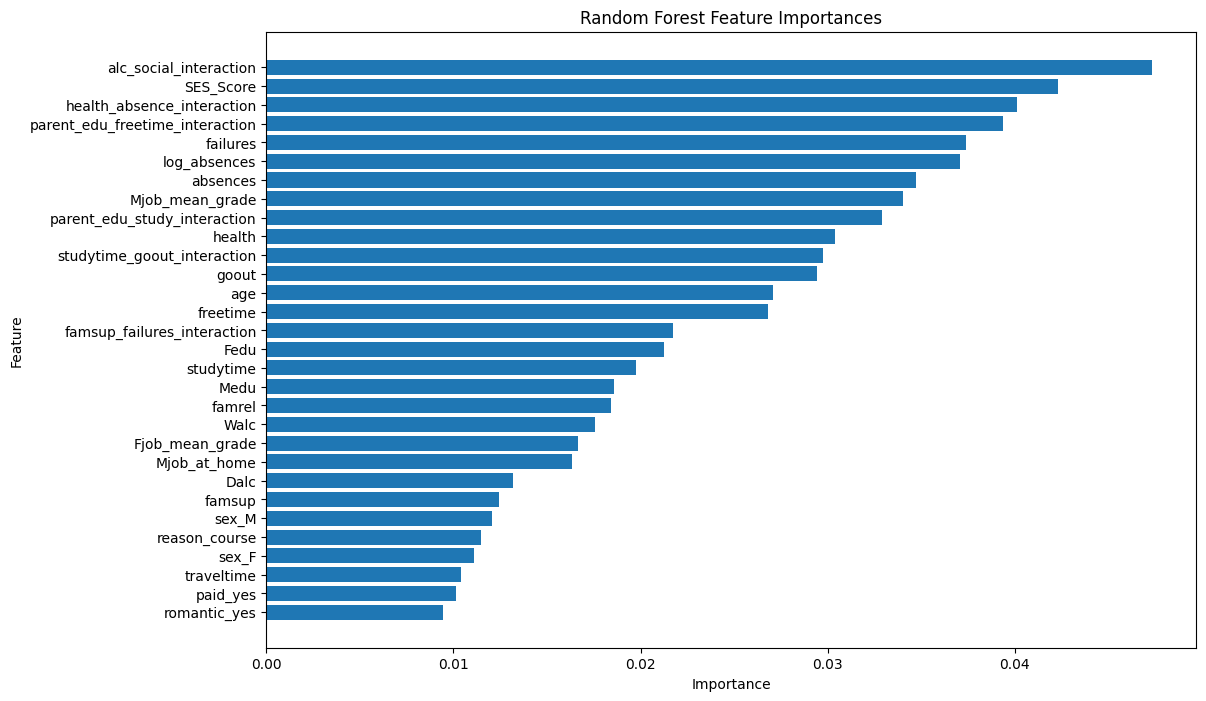

In [ ]:
top_features = importances_rf_full.head(30)

plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# function to evaluate models
def evaluate_model(model, model_name, X_train, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))
    y_pred_prob = model.predict_proba(X_test)
    print(f'{model_name} Prediction Probabilities (First 5 Predictions):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [ ]:
# evaluate Grid and Randomised search
def evaluate_search(search_obj, search_type, X_test, y_test):
    print(f"Best parameters found by {search_type}: ", search_obj.best_params_)
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print(f'Classification Report of the best model ({search_type}):')
    print(classification_report(y_test, y_pred))
    y_pred_prob = best_model.predict_proba(X_test)
    print(f'Prediction Probabilities (First 5 Predictions) of the best model ({search_type}):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [ ]:
# retrain rf model with the top 30 features
top_30_features = importances_rf_full.head(15)['Feature']

# Create new datasets with only the top 30 features
X_train_reduced = X_train[top_30_features]
X_test_reduced = X_test[top_30_features]

# Retrain Random Forest on the reduced feature set
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

# Make predictions and evaluate the model
y_pred_rf_reduced = rf_reduced.predict(X_test_reduced)
accuracy_rf_reduced = accuracy_score(y_test, y_pred_rf_reduced)
print(f"Random Forest Accuracy (Top 30 Features): {accuracy_rf_reduced}")

# Compare with the full feature model
print(f"Accuracy Improvement: {accuracy_rf_reduced - accuracy_rf_full}")


Random Forest Accuracy (Top 30 Features): 0.6218487394957983
Accuracy Improvement: -0.008403361344537785


In [ ]:
# Refined parameter grid
refined_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 8, 10, 12],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6]
}
rf = RandomForestClassifier(random_state=42, n_estimators=100)
refined_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=refined_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring = 'accuracy')

refined_grid_search.fit(X_train_reduced, y_train)

In [ ]:
evaluate_search(refined_grid_search, "GridSearch", X_test_reduced, y_test)

Best parameters found by GridSearch:  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy of the best model: 0.6302521008403361
Classification Report of the best model (GridSearch):
              precision    recall  f1-score   support

           0       0.71      0.51      0.59        63
           1       0.58      0.77      0.66        56

    accuracy                           0.63       119
   macro avg       0.65      0.64      0.63       119
weighted avg       0.65      0.63      0.63       119

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch):
[[0.72697679 0.27302321]
 [0.69882957 0.30117043]
 [0.39383292 0.60616708]
 [0.55479533 0.44520467]
 [0.70326979 0.29673021]]
--------------------------------------------------


In [ ]:
rf_pipeline = ImbPipeline([
     #('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
param_grid_rf2 = {
    'rf__max_depth': [10, 12, 14],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__min_samples_split': [2, 3],
    'rf__n_estimators': [50, 100, 150]
}

grid_search_rf2 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf2,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_rf2.fit(X_train_reduced, y_train)

In [ ]:
evaluate_search(grid_search_rf2, "GridSearch", X_test_reduced, y_test)

Best parameters found by GridSearch:  {'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Accuracy of the best model: 0.6218487394957983
Classification Report of the best model (GridSearch):
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        63
           1       0.58      0.71      0.64        56

    accuracy                           0.62       119
   macro avg       0.63      0.63      0.62       119
weighted avg       0.63      0.62      0.62       119

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch):
[[0.73452858 0.26547142]
 [0.84607961 0.15392039]
 [0.49896642 0.50103358]
 [0.62788296 0.37211704]
 [0.72201596 0.27798404]]
--------------------------------------------------


In [ ]:
param_dist_rf = {
    'rf__max_depth': randint(10, 15),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__min_samples_split': randint(2, 5),
    'rf__n_estimators': randint(80, 120)
}

random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)
random_search_rf.fit(X_train_reduced, y_train)


In [ ]:
evaluate_search(random_search_rf, "RandomisedSearch", X_test_reduced, y_test)

Best parameters found by RandomisedSearch:  {'rf__max_depth': 12, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 115}
Accuracy of the best model: 0.6302521008403361
Classification Report of the best model (RandomisedSearch):
              precision    recall  f1-score   support

           0       0.69      0.56      0.61        63
           1       0.59      0.71      0.65        56

    accuracy                           0.63       119
   macro avg       0.64      0.63      0.63       119
weighted avg       0.64      0.63      0.63       119

Prediction Probabilities (First 5 Predictions) of the best model (RandomisedSearch):
[[0.73324002 0.26675998]
 [0.83964458 0.16035542]
 [0.48442699 0.51557301]
 [0.63159075 0.36840925]
 [0.6913078  0.3086922 ]]
--------------------------------------------------


In [ ]:
param_dist_rf_adjusted = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': [10, 12, 15, 20, None],
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf_stratified = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf_adjusted,
    n_iter=100,
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)

random_search_rf_stratified.fit(X_train_reduced, y_train)


In [ ]:
evaluate_search(random_search_rf_stratified, "RandomisedSearch", X_test_reduced, y_test)

Best parameters found by RandomisedSearch:  {'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 66}
Accuracy of the best model: 0.6386554621848739
Classification Report of the best model (RandomisedSearch):
              precision    recall  f1-score   support

           0       0.69      0.57      0.63        63
           1       0.60      0.71      0.65        56

    accuracy                           0.64       119
   macro avg       0.64      0.64      0.64       119
weighted avg       0.65      0.64      0.64       119

Prediction Probabilities (First 5 Predictions) of the best model (RandomisedSearch):
[[0.76085859 0.23914141]
 [0.88250361 0.11749639]
 [0.55025253 0.44974747]
 [0.61679293 0.38320707]
 [0.74621212 0.25378788]]
--------------------------------------------------


## XGB

In [ ]:
strat_k_fold = StratifiedKFold(n_splits=5)

xgb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(objective='binary:logistic', random_state=42))
])

In [ ]:
param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_xgb.fit(X_train_reduced, y_train)

In [ ]:
evaluate_search(grid_search_xgb, "RandomisedSearch", X_test_reduced, y_test)

Best parameters found by RandomisedSearch:  {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__subsample': 0.7}
Accuracy of the best model: 0.6386554621848739
Classification Report of the best model (RandomisedSearch):
              precision    recall  f1-score   support

           0       0.72      0.52      0.61        63
           1       0.59      0.77      0.67        56

    accuracy                           0.64       119
   macro avg       0.65      0.65      0.64       119
weighted avg       0.66      0.64      0.63       119

Prediction Probabilities (First 5 Predictions) of the best model (RandomisedSearch):
[[0.7495917  0.25040832]
 [0.7964769  0.20352308]
 [0.53467524 0.46532473]
 [0.5928131  0.40718693]
 [0.76993585 0.23006414]]
--------------------------------------------------


In [ ]:
param_grid_xgb_refined = {
    'xgb__n_estimators': [100, 300, 500],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb_refined = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb_refined,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search_xgb_refined.fit(X_train_reduced, y_train)


In [ ]:
evaluate_search(grid_search_xgb_refined, "Gridsearch", X_test_reduced, y_test)

Best parameters found by RandomisedSearch:  {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 300, 'xgb__subsample': 1.0}
Accuracy of the best model: 0.5882352941176471
Classification Report of the best model (RandomisedSearch):
              precision    recall  f1-score   support

           0       0.71      0.38      0.49        63
           1       0.54      0.82      0.65        56

    accuracy                           0.59       119
   macro avg       0.62      0.60      0.57       119
weighted avg       0.63      0.59      0.57       119

Prediction Probabilities (First 5 Predictions) of the best model (RandomisedSearch):
[[0.8553444  0.14465556]
 [0.8882177  0.11178229]
 [0.4506216  0.5493784 ]
 [0.39338607 0.60661393]
 [0.7977259  0.20227407]]
--------------------------------------------------


In [ ]:
param_dist_xgb = {
    'xgb__n_estimators': randint(100, 500),
    'xgb__learning_rate': uniform(0.01, 0.1),
    'xgb__max_depth': randint(3, 7),
    'xgb__subsample': uniform(0.8, 0.2),
    'xgb__colsample_bytree': uniform(0.7, 0.2)
}

random_search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist_xgb,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)

random_search_xgb.fit(X_train_reduced, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=N...
                                        'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d5a7f7961d0>,
                                        'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d5a7f7aa020>,
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d5a7d4e3640>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d5a7f7a96f0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
evaluate_search(random_search_xgb, "Gridsearch", X_test_reduced, y_test)

Best parameters found by Gridsearch:  {'xgb__colsample_bytree': 0.8406037917790355, 'xgb__learning_rate': 0.0463629602379294, 'xgb__max_depth': 3, 'xgb__n_estimators': 151, 'xgb__subsample': 0.8493752125677203}
Accuracy of the best model: 0.6134453781512605
Classification Report of the best model (Gridsearch):
              precision    recall  f1-score   support

           0       0.72      0.44      0.55        63
           1       0.56      0.80      0.66        56

    accuracy                           0.61       119
   macro avg       0.64      0.62      0.61       119
weighted avg       0.64      0.61      0.60       119

Prediction Probabilities (First 5 Predictions) of the best model (Gridsearch):
[[0.82791644 0.17208357]
 [0.83997285 0.16002718]
 [0.6133846  0.38661543]
 [0.57842803 0.421572  ]
 [0.8826054  0.11739462]]
--------------------------------------------------


## SVM

In [ ]:
svm_classifier = SVC(kernel='linear', random_state=42, probability=True)
svm_classifier.fit(X_train_reduced, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [ ]:
evaluate_model(svm_classifier, "svm", X_train_reduced, X_test_reduced, y_test)

svm Accuracy: 0.6638655462184874
svm Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.46      0.59        63
           1       0.60      0.89      0.71        56

    accuracy                           0.66       119
   macro avg       0.71      0.68      0.65       119
weighted avg       0.72      0.66      0.65       119

svm Prediction Probabilities (First 5 Predictions):
[[0.78473529 0.21526471]
 [0.44017874 0.55982126]
 [0.57463388 0.42536612]
 [0.45039487 0.54960513]
 [0.72550381 0.27449619]]
--------------------------------------------------


In [ ]:
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

In [ ]:
# Define parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 'auto']
}

# Grid search
svm_grid_search = GridSearchCV(svm_pipeline,
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)

svm_grid_search.fit(X_train_reduced, y_train)




Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [ ]:
evaluate_search(svm_grid_search, "Gridsearch", X_test_reduced, y_test)

Best parameters found by Gridsearch:  {'svm__C': 0.1, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Accuracy of the best model: 0.6470588235294118
Classification Report of the best model (Gridsearch):
              precision    recall  f1-score   support

           0       0.71      0.56      0.63        63
           1       0.60      0.75      0.67        56

    accuracy                           0.65       119
   macro avg       0.66      0.65      0.65       119
weighted avg       0.66      0.65      0.64       119

Prediction Probabilities (First 5 Predictions) of the best model (Gridsearch):
[[0.81056788 0.18943212]
 [0.59047183 0.40952817]
 [0.6572925  0.3427075 ]
 [0.57317152 0.42682848]
 [0.79706173 0.20293827]]
--------------------------------------------------


In [ ]:
param_distributions = {
    'svm__C': uniform(0.1, 10),
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__degree': [2, 3, 4, 5],
    'svm__gamma': ['scale', 'auto']
}
random_searchsvm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions,
    n_iter=100, cv=strat_k_fold,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_searchsvm.fit(X_train_reduced, y_train)


In [ ]:
evaluate_search(random_searchsvm, "RandomisedSearch", X_test_reduced, y_test)

Best parameters found by Gridsearch:  {'svm__C': 3.6864678129616393, 'svm__degree': 4, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Accuracy of the best model: 0.6386554621848739
Classification Report of the best model (Gridsearch):
              precision    recall  f1-score   support

           0       0.72      0.52      0.61        63
           1       0.59      0.77      0.67        56

    accuracy                           0.64       119
   macro avg       0.65      0.65      0.64       119
weighted avg       0.66      0.64      0.63       119

Prediction Probabilities (First 5 Predictions) of the best model (Gridsearch):
[[0.66536243 0.33463757]
 [0.80746113 0.19253887]
 [0.62300451 0.37699549]
 [0.71756606 0.28243394]
 [0.59679409 0.40320591]]
--------------------------------------------------


## Model stacking

In [ ]:
base_rf = RandomForestClassifier(random_state=42)
ada_boost_rf = AdaBoostClassifier(estimator=base_rf, random_state=42, n_estimators=50)
ada_boost_rf.fit(X_train_reduced, y_train)

evaluate_model(ada_boost_rf, "ada", X_train_reduced, X_test_reduced, y_test)

ada Accuracy: 0.6386554621848739
ada Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.48      0.58        63
           1       0.58      0.82      0.68        56

    accuracy                           0.64       119
   macro avg       0.67      0.65      0.63       119
weighted avg       0.67      0.64      0.63       119

ada Prediction Probabilities (First 5 Predictions):
[[0.77 0.23]
 [0.75 0.25]
 [0.54 0.46]
 [0.58 0.42]
 [0.7  0.3 ]]
--------------------------------------------------


In [ ]:
ada_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada_boost_rf', AdaBoostClassifier(
        estimator=RandomForestClassifier(random_state=42),
        random_state=42))
])

param_dist = {
    'ada_boost_rf__n_estimators': randint(30, 100),
    'ada_boost_rf__learning_rate': [0.01, 0.1, 1]
}

random_searchada = RandomizedSearchCV(
    ada_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_searchada.fit(X_train_reduced, y_train)

In [ ]:
evaluate_search(random_searchada, "Gridsearch", X_test_reduced, y_test)

Best parameters found by Gridsearch:  {'ada_boost_rf__learning_rate': 1, 'ada_boost_rf__n_estimators': 81}
Accuracy of the best model: 0.6302521008403361
Classification Report of the best model (Gridsearch):
              precision    recall  f1-score   support

           0       0.72      0.49      0.58        63
           1       0.58      0.79      0.67        56

    accuracy                           0.63       119
   macro avg       0.65      0.64      0.63       119
weighted avg       0.65      0.63      0.62       119

Prediction Probabilities (First 5 Predictions) of the best model (Gridsearch):
[[0.79 0.21]
 [0.81 0.19]
 [0.48 0.52]
 [0.65 0.35]
 [0.72 0.28]]
--------------------------------------------------


In [ ]:
def get_search_pred(search_obj, X_test, y_test):
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print("Classification Report of the best model:", {best_model})
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob

In [ ]:
def get_model_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob

In [ ]:
y_test1, y_pred1, y_pred_prob1 = get_model_pred(svm_classifier, X_test_reduced, y_test) #svm
y_test_gs3, y_pred_gs3, y_pred_prob_gs3 = get_search_pred(grid_search_xgb, X_test_reduced, y_test) # xgb
y_test_gs4, y_pred_gs4, y_pred_prob_gs4 = get_search_pred(refined_grid_search, X_test_reduced, y_test) # rf
y_test_gs5, y_pred_gs5, y_pred_prob_gs5 = get_search_pred(random_searchada, X_test_reduced, y_test) # ada

Accuracy: 0.6638655462184874
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.46      0.59        63
           1       0.60      0.89      0.71        56

    accuracy                           0.66       119
   macro avg       0.71      0.68      0.65       119
weighted avg       0.72      0.66      0.65       119

Accuracy of the best model: 0.6386554621848739
Classification Report of the best model: {Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_pol

In [ ]:
# Binarize the labels
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test).ravel()


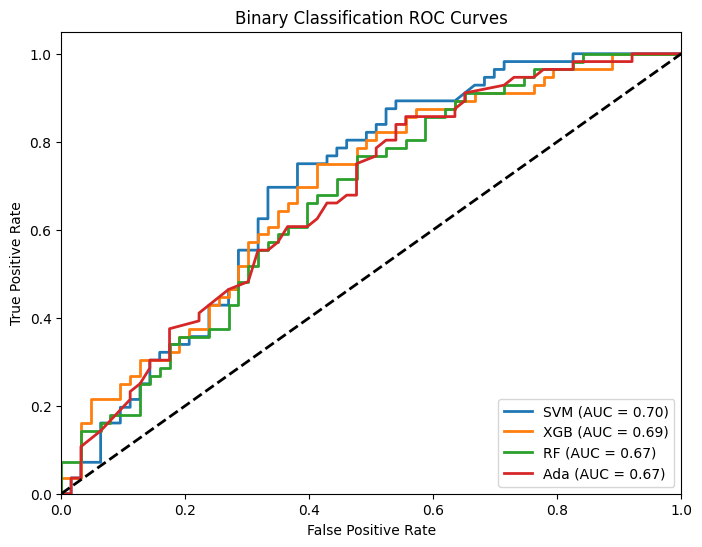

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve for each model
def plot_binary_roc_curve(y_true, y_score, ax, name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:0.2f})',
            linestyle='-', linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))

#plot_binary_roc_curve(y_test_binarized, y_pred_prob_gs1, ax, 'LR')
plot_binary_roc_curve(y_test_binarized, y_pred_prob1, ax, 'SVM')
plot_binary_roc_curve(y_test_binarized, y_pred_prob_gs3, ax, 'XGB')
plot_binary_roc_curve(y_test_binarized, y_pred_prob_gs4, ax, 'RF')
plot_binary_roc_curve(y_test_binarized, y_pred_prob_gs5, ax, 'Ada')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Binary Classification ROC Curves')
ax.legend(loc="lower right")

plt.show()


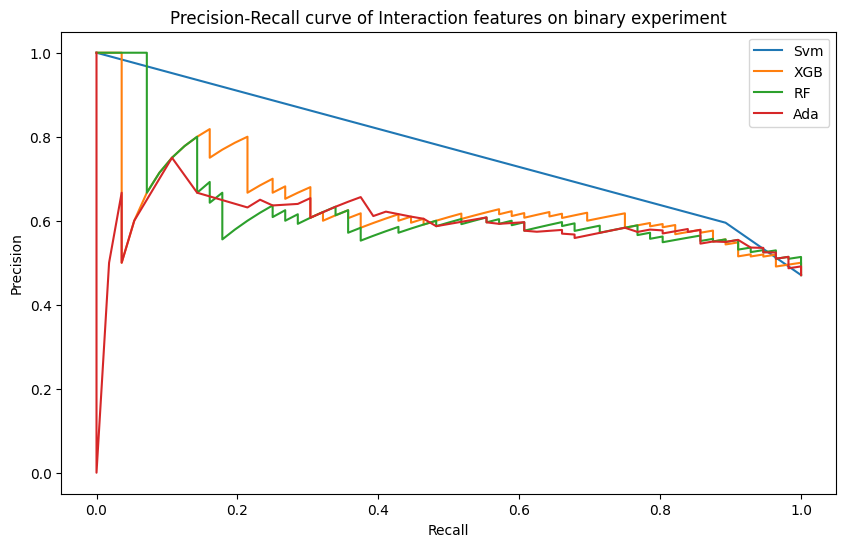

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall for each model
precision_gs2, recall_gs2, _ = precision_recall_curve(y_test1, y_pred1)
precision_gs3, recall_gs3, _ = precision_recall_curve(y_test_gs3, y_pred_prob_gs3)
precision_gs4, recall_gs4, _ = precision_recall_curve(y_test_gs4, y_pred_prob_gs4)
precision_gs5, recall_gs5, _ = precision_recall_curve(y_test_gs5, y_pred_prob_gs5)

# Plotting the precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_gs2, precision_gs2, label="Svm")
plt.plot(recall_gs3, precision_gs3, label="XGB")
plt.plot(recall_gs4, precision_gs4, label="RF")
plt.plot(recall_gs5, precision_gs5, label="Ada")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve of Interaction features on binary experiment")
plt.legend()
plt.show()

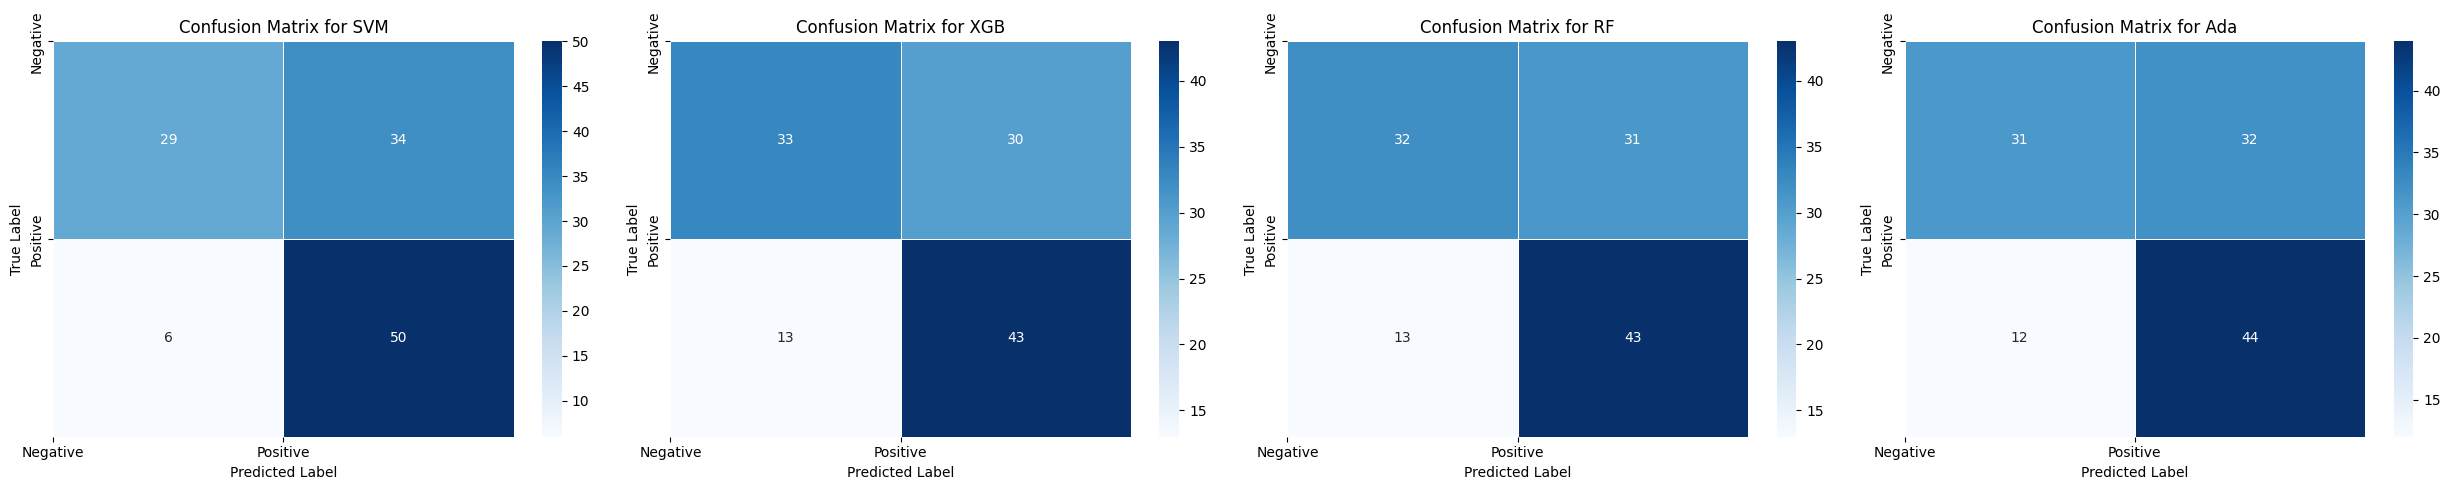

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, ax, model_name, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap=cmap)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticks(np.arange(len(np.unique(y_true))))
    ax.set_yticks(np.arange(len(np.unique(y_true))))
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])

true_labels = [ y_test1, y_test_gs3, y_test_gs4, y_test_gs5]
predicted_labels = [ y_pred1, y_pred_gs3, y_pred_gs4, y_pred_gs5]
model_names = ['SVM', 'XGB', 'RF', 'Ada']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
for ax, y_true, y_pred, model_name in zip(axes, true_labels, predicted_labels, model_names):
    plot_confusion_matrix(y_true, y_pred, ax, model_name)

plt.tight_layout()
plt.show()